# 1 - Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools
import datetime

import sys
sys.path.append("..")

from state_prep_opt import *

# 2 - Settings

In [12]:
settings = {
    "measure": None,
    "blocks": 5,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 40,
    "state": {
        "mode": "squeeze",
        "squeezing_dB": 8 
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 35,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": False
}

def generate_state(settings, large=False):
    z = jqt.squeezing_dB_to_linear(settings["state"]["squeezing_dB"])
    N = settings["N" if not large else "N_large"]
    target_state_cavity = jqt.squeeze(N, z) @ jqt.basis(N, 0)
    return target_state_cavity

target_state_cavity = generate_state(settings, large=False)
settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x16dd9ebb0>)

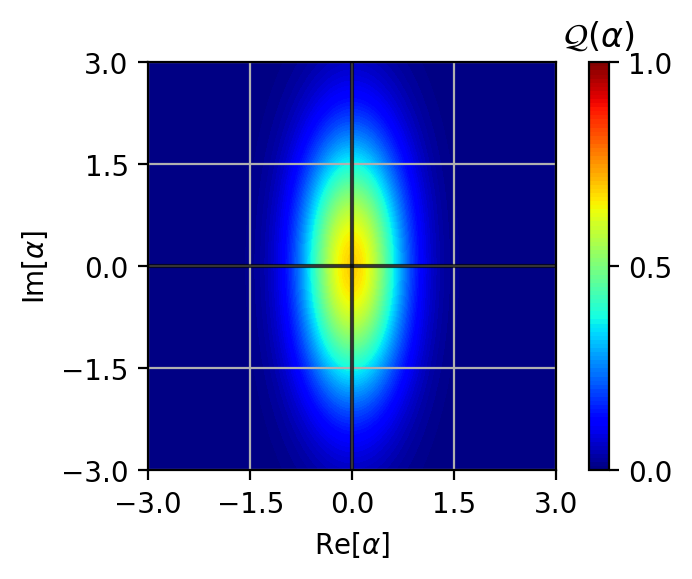

In [13]:
jqt.plot_qfunc(settings["target_state"], jnp.linspace(-3,3,200))

# 4 - Batch Gradient Descent

In [4]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [5]:
# Functions


# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"], settings["reg_mode"], settings["reg_strength"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

17.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
77.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
18.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
history = optimize(random_initial_params, settings)

Running for 1,000 iterations: 100%|█████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.82it/s]


In [7]:
fids_history = history["fids"]
metric_batch_history = history["metric_batch"]
params_history = history["params"]
metric_history = history["metric"]

In [8]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
fidelity_best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]
metric_best_fid = jnp.array(metric_batch_history)[best_fid_epoch_indx, best_fid_batch_indx]

In [9]:
best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(jnp.array(metric_batch_history)), jnp.array(metric_batch_history).shape)
metric_best_metric = jnp.array(metric_batch_history)[best_metric_epoch_indx, best_metric_batch_indx]
fidelity_best_metric = jnp.array(fids_history)[best_metric_epoch_indx, best_metric_batch_indx]

In [17]:
if settings["minimize_metric"] == False:
    best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]
np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

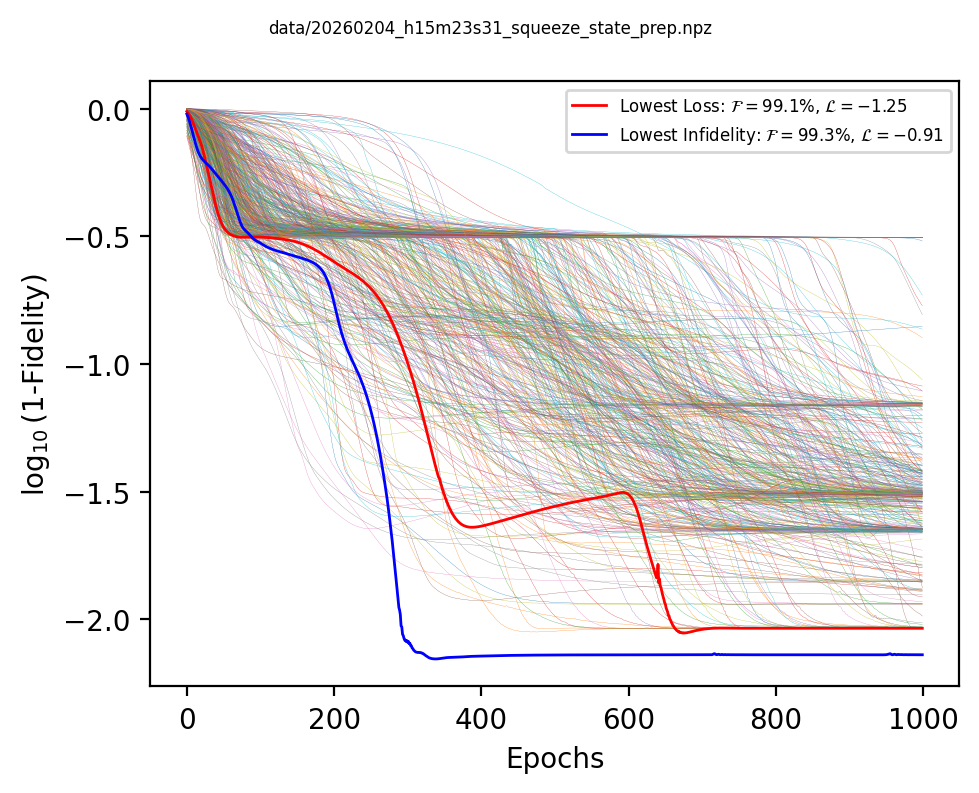

In [25]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_metric_batch_indx]), linestyle='-', linewidth=1, color='red', label=f"Lowest Loss: $\\mathcal{{F}}={fidelity_best_metric*100:.1f}\%$, $\\mathcal{{L}}={metric_best_metric:.2f}$")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=1, color='blue', label=f"Lowest Infidelity: $\\mathcal{{F}}={fidelity_best_fid*100:.1f}\%$, $\\mathcal{{L}}={metric_best_fid:.2f}$")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)
fig.suptitle(settings["data_filename"], fontsize=6)
fig.tight_layout()

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14e0b8392d40>)

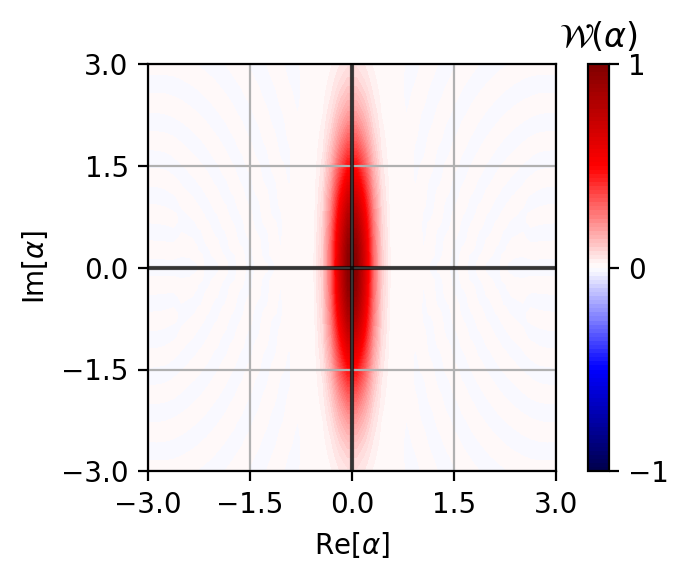

In [19]:
pts = jnp.linspace(-3, 3, 50)
jqt.plot_wigner(target_state_cavity, pts)

(array([[<Axes: xlabel='Re[$\\alpha$]', ylabel='Im[$\\alpha$]'>]],
       dtype=object),
 <matplotlib.contour.QuadContourSet at 0x14e0b8267e50>)

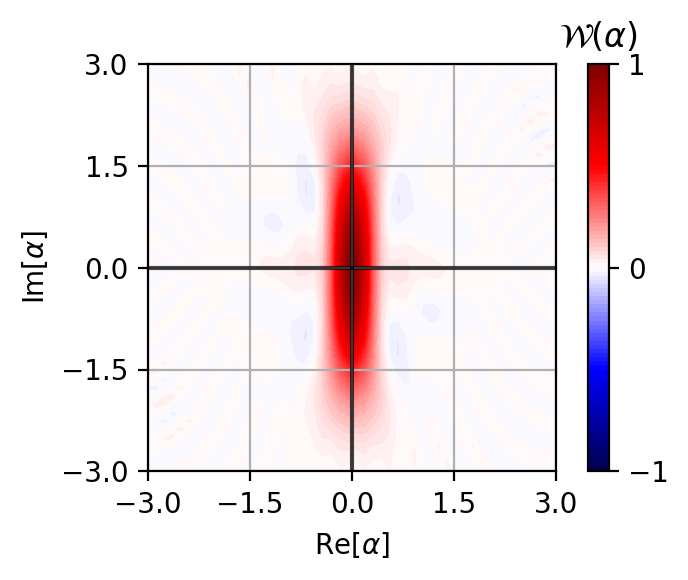

In [20]:
pts = jnp.linspace(-3, 3, 50)
prepared_state = run_circuit(params_history[best_metric_epoch_indx, best_metric_batch_indx], settings["N"])
jqt.plot_wigner(prepared_state, pts)

In [21]:
# data=np.load(r"./data/20251014_h16m53s23_fock_state_prep_plusx.npz", allow_pickle=True)
# optimal_instructions = data["best_params"]

# best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

# prepared_state = run_circuit(best_params, 100)

Best parameters: 
 [[ 0.43135   0.346334  0.632757  0.730047  0.749998]
 [ 0.25      0.442416  0.971437  0.474651  0.753181]
 [-0.155444 -0.555359  1.124969  0.328676 -0.      ]
 [-1.980031 -0.982912 -1.128842  0.014036  0.      ]]


Text(0.5, 1.02, '20260204_h15m23s31_squeeze_state_prep.npz, $\\vert squeeze\\rangle,$ $\\mathcal{F}=0.991$, $N_B=5$, $\\beta=0.5$')

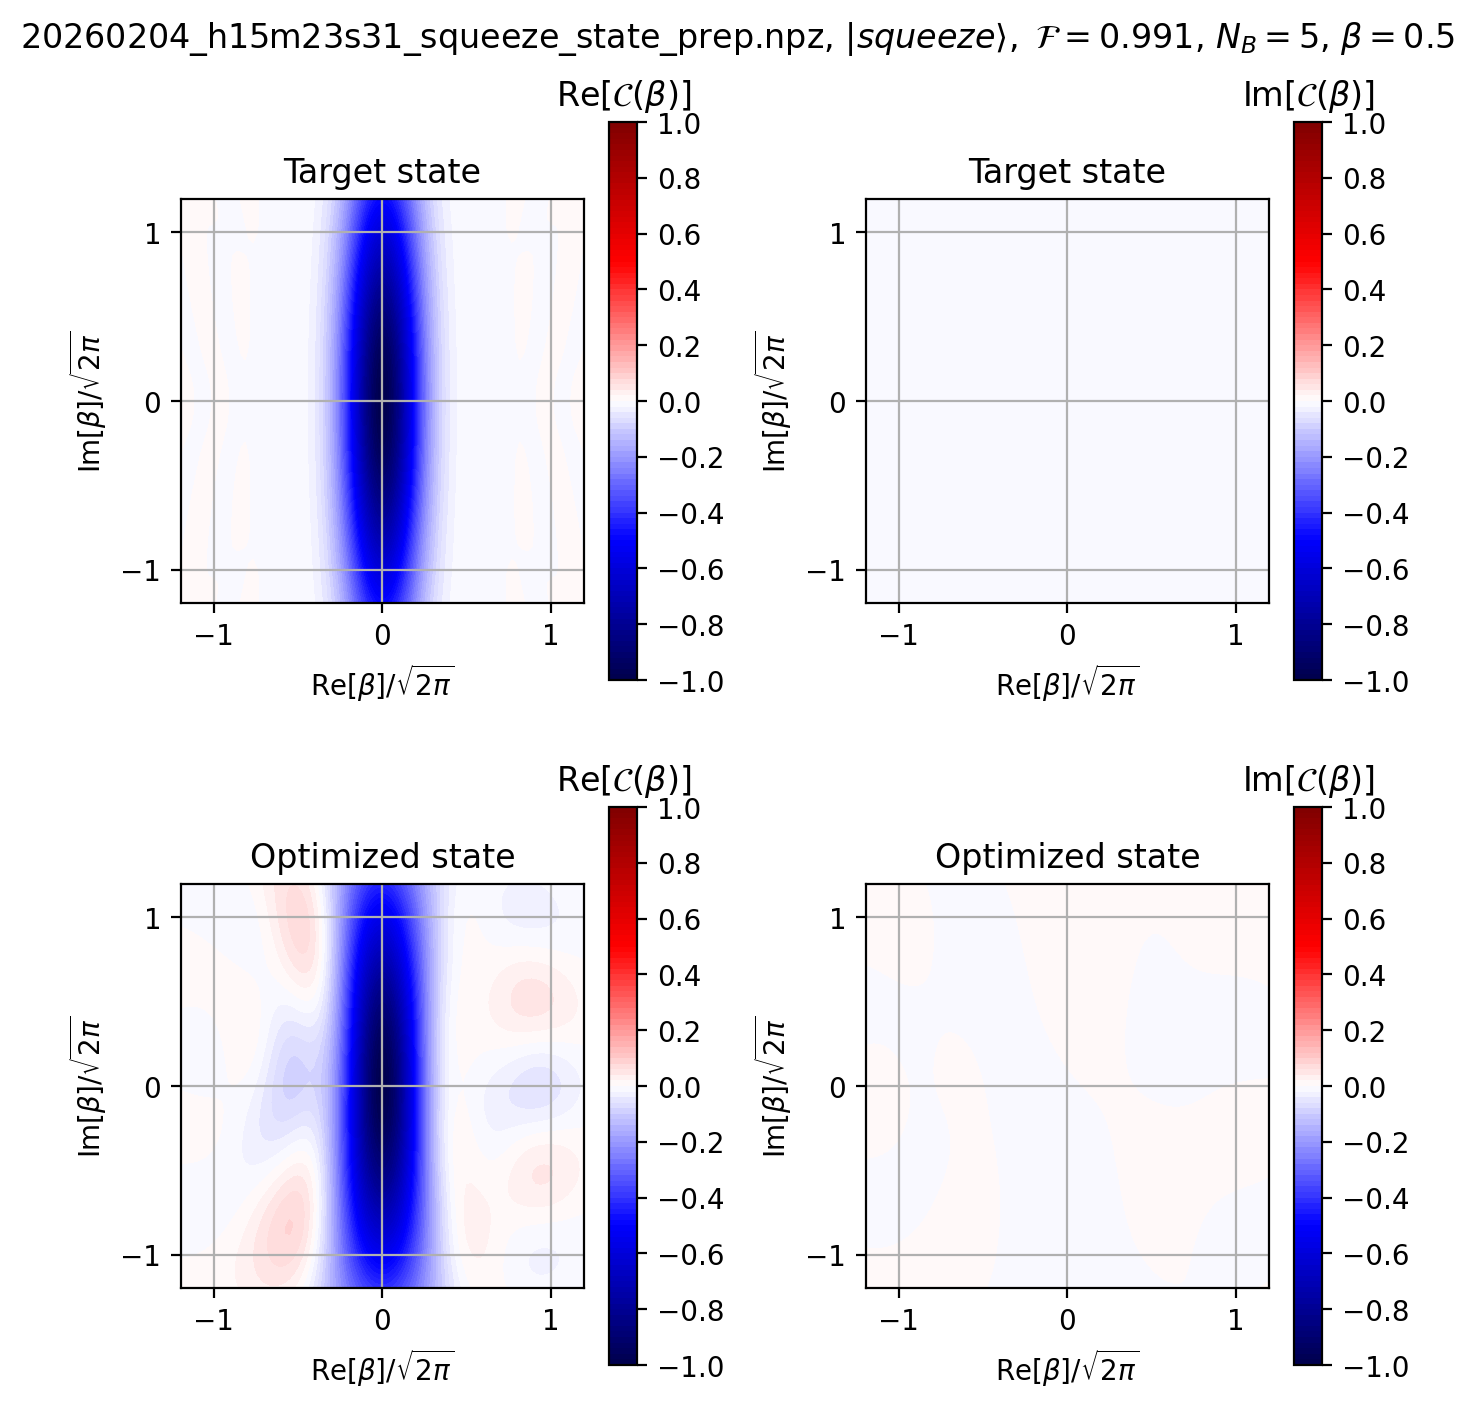

In [22]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(7,7))
axs = axs.flatten()
print("Best parameters: \n", best_params)
N_large = settings["N_large"]
target_state_larger = jqt.basis(2,0) ^ generate_state(settings, large=True)

prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)


betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")



fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert {settings['state']['mode']}\\rangle,$ $\\mathcal{{F}}={fid:.3f}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)